# Simulation of an Assembly of CoNRS aligned under a magnetic field

We aim to simulate SAXS image of CoNRs aligned under a magnetic field. As the experimental nanorods are large, we first \texttbf{ divide sizes and distances by a factor 5}, in order to obtain relatively fast computations of scattered images.

The nanorods have the following properties:
- $radius = 5\AA$
- $length = 134\AA$

In solution, the nanorods arrange as lamellae, spaced by $dx = 139.6 \AA$.

In each lamella, the nanorods form a 2D hexagonal lattice (in the (y,z) plane), with lattice parameter $a = 15.6 \AA$


![](figs/honeycomb.png)



In [1]:
%matplotlib widget

import numpy as np
import os
from debye3D import Experiment, Debye3D
import math
from utilities import *


## Define experiment

In [2]:
wl = 1.54
distance = 0.36
npix = 500
pix_size = 0.0006 # 600µum
exp = Experiment(wl=wl, distance=distance,npix=npix,pixel_size=pix_size)

----------------------------------------------------
 Detector configuration / accessible Q-range
----------------------------------------------------
 Wavelength λ = 1.5400 Å
 Sample-detector distance = 360.00 mm
 Pixel size = 0.600 mm
 Number of pixels = 500 x 500
 Qx range : -1.5692 → 1.5639 Å⁻¹
 Qy range : -0.5649 → 0.0000 Å⁻¹
 Qz range : -1.5692 → 1.5639 Å⁻¹
 |Q| range : 0.0000 → 2.1469 Å⁻¹
----------------------------------------------------



## I. Compute form factor
1. Generate cylinder structure

In [3]:
cif_file = './structures/Co_P63mmc.cif'
xyz_file = make_cylinder_from_cif(cif_file, R = 5, L= 134, output_file='./structures/cylinder_Co.xyz')  # function from utilities

/home-local/ratel-ra/anaconda3_c/envs/py311/lib/python3.11/site-packages/ase/utils/__init__.py:62: FutureWarning: Please use atoms.cell.cellpar() instead
  warnings.warn(warning)


2. Create Debye3D instance and compute form factor

----------------------------------------------------
 Detector configuration / accessible Q-range
----------------------------------------------------
 Wavelength λ = 1.5400 Å
 Sample-detector distance = 360.00 mm
 Pixel size = 0.600 mm
 Number of pixels = 500 x 500
 Qx range : -1.5692 → 1.5639 Å⁻¹
 Qy range : -0.5649 → 0.0000 Å⁻¹
 Qz range : -1.5692 → 1.5639 Å⁻¹
 |Q| range : 0.0000 → 2.1469 Å⁻¹
----------------------------------------------------


 Structure contains 792 atoms.



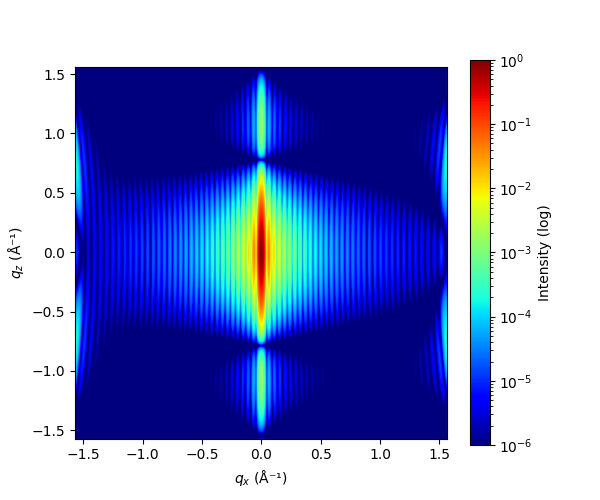

In [4]:
d = Debye3D(xyz_file,distance= exp.distance,npix=exp.npix,wl=exp.wl,pixel_size=exp.pixel_size)

# align cylinder along x axis
d.rotate_positions(alpha=0,beta=90,gamma=0)

# compute scattering (unique object _ form factor)
Pq = d.compute_intensity()
d.plot_intensity(Pq)

### Compute polydisperse form factor

Polydispersity on both length and radius. Simple loops.

r_mean = 5
L_mean=134
r_PD_ratio = 0.1 -> $\sigma_r = 0.5$
L_PD_ratio = 0.1 -> $\sigma_L=13.4$




In [5]:
def compute_cylinder_intensity(r,L):
    xyz_file = make_cylinder_from_cif(cif_file, R = r, L= L, output_file='./structures/cylinder_Co_polydisp.xyz')
    d = Debye3D(xyz_file,distance= exp.distance,npix=exp.npix,wl=exp.wl,pixel_size=exp.pixel_size, verbose = False)
    # align cylinder along x axis
    d.rotate_positions(alpha=0,beta=90,gamma=0)
    # compute scattering (unique object _ form factor)
    Pq = d.compute_intensity()
    os.remove(xyz_file) # delte structure file
    return Pq


/home-local/ratel-ra/anaconda3_c/envs/py311/lib/python3.11/site-packages/ase/utils/__init__.py:62: FutureWarning: Please use atoms.cell.cellpar() instead
  warnings.warn(warning)


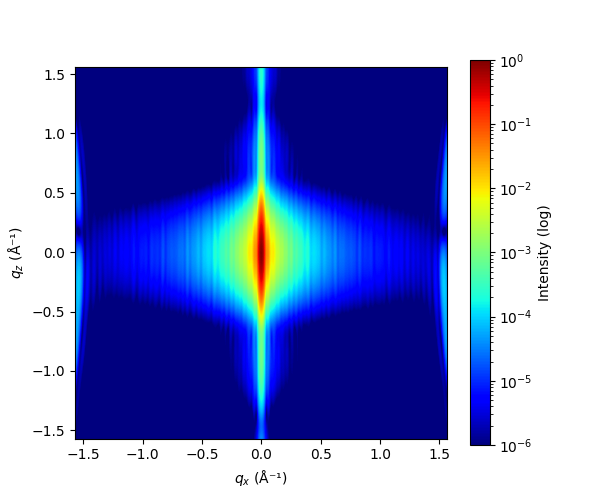

In [6]:
def monte_carlo_polydisp_intensity(compute_func, mu_r, PD_ratio_r, mu_L, PD_ratio_L, N=50, plot=True,npix=256):
    """
    Estime l'intensité moyenne et l'incertitude d'un cylindre en utilisant Monte-Carlo.

    Parameters
    ----------
    compute_func : function
        Fonction qui prend (r, L) et renvoie Pq (image 2D).
    mu_r : float
        Moyenne de r.
    sigma_r : float
        Écart-type de r.
    mu_L : float
        Moyenne de L.
    sigma_L : float
        Écart-type de L.
    N : int
        Nombre d'échantillons Monte-Carlo.
    plot : bool
        Si True, affiche les images de moyenne et d'écart-type.

    Returns
    -------
    Pq_mean : ndarray
        Image moyenne sur N échantillons.
    Pq_std : ndarray
        Écart-type pixel par pixel.
    """
    sigma_r =PD_ratio_r * mu_r
    sigma_L =PD_ratio_L * mu_L
    # Échantillons r et L
    r_samples = np.random.normal(mu_r, sigma_r, N)
    L_samples = np.random.normal(mu_L, sigma_L, N)

    # Calcul test pour connaître la forme de Pq
    Pq_test = compute_func(r_samples[0], L_samples[0])
    height, width = npix,npix

    # Stockage des images Monte-Carlo
    Pq_all = np.zeros((N, height, width))

    # Monte-Carlo loop
    for i in range(N):
        Pq = compute_func(r_samples[i], L_samples[i])
        Pq=Pq.reshape([npix,npix])
        Pq_all[i, :, :] = Pq

    # Average
    Pq_mean = np.mean(Pq_all, axis=0)
    

    d.plot_intensity(Pq_mean)
    return Pq_mean


Pq_mean = monte_carlo_polydisp_intensity(
    compute_func=compute_cylinder_intensity,
    mu_r=5, PD_ratio_r=0.15,
    mu_L=134, PD_ratio_L=0.2,
    N=20,plot = True, npix=exp.npix)



-> save data to npz

In [7]:
file ='./CoNRs_polydisp.npz'
save_intensity_npz(file,Pq_mean,d.Qx,d.Qz)

Saved intensity map to './CoNRs_polydisp.npz'


## Combine orientation and size distribution

/home-local/ratel-ra/anaconda3_c/envs/py311/lib/python3.11/site-packages/ase/utils/__init__.py:62: FutureWarning: Please use atoms.cell.cellpar() instead
  warnings.warn(warning)


Iteration 0/20
Iteration 1/20
Iteration 2/20
Iteration 3/20
Iteration 4/20
Iteration 5/20
Iteration 6/20
Iteration 7/20
Iteration 8/20
Iteration 9/20
Iteration 10/20
Iteration 11/20
Iteration 12/20
Iteration 13/20
Iteration 14/20
Iteration 15/20
Iteration 16/20
Iteration 17/20
Iteration 18/20
Iteration 19/20


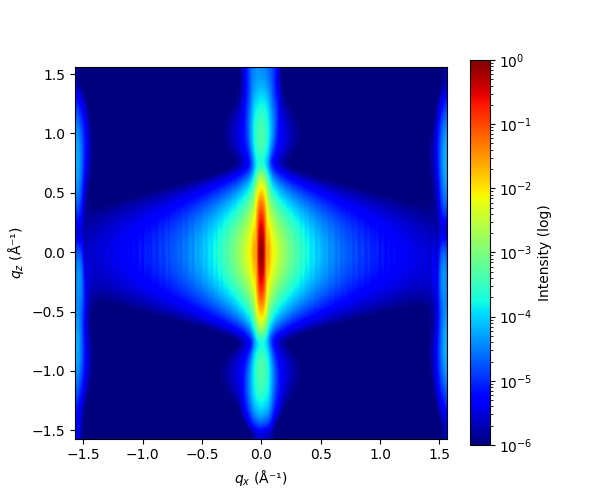

In [9]:
def compute_cylinder_intensity_uniaxial_ODF(r,L,n_samples_uniaxial=20, sigma_y =2,sigma_z=2):
    xyz_file = make_cylinder_from_cif(cif_file, R = r, L= L)
    d = Debye3D(xyz_file,distance= exp.distance,npix=exp.npix,wl=exp.wl,pixel_size=exp.pixel_size, verbose = False)
    # align cylinder along x axis
    d.rotate_positions(alpha=0,beta=90,gamma=0)
    # compute scattering (unique object _ form factor)
    Pq = d.compute_intensity_uniaxial_ODF(n_samples = n_samples_uniaxial, sigma_y=sigma_y,sigma_z=sigma_z)
    os.remove(xyz_file)
    return Pq

def monte_carlo_polydisp_intensity(
    compute_func, 
    mu_r, 
    PD_ratio_r, 
    mu_L, 
    PD_ratio_L, 
    N=50, 
    plot=True,
    npix=256,
    n_samples_uniaxial=20,
    sigma_y=2,
    sigma_z=2):
    """
    Estime l'intensité moyenne et l'incertitude d'un cylindre en utilisant Monte-Carlo.

    Parameters
    ----------
    compute_func : function
        Fonction qui prend (r, L) et renvoie Pq (image 2D).
    mu_r : float
        Moyenne de r.
    sigma_r : float
        Écart-type de r.
    mu_L : float
        Moyenne de L.
    sigma_L : float
        Écart-type de L.
    N : int
        Nombre d'échantillons Monte-Carlo pour la distribution de taille
    plot : bool
        Si True, affiche les images de moyenne et d'écart-type.
    n_samples_uniaxial: int
        Nombre d'échantillons Monte-Carlo pour la distribution d'orientation
    sigma_y: float
        Ecart type de la distribution d'orientation gaussienne autour de y
    sigma_z: float
        Ecart type de la distribution d'orientation gaussienne autour de z

    Returns
    -------
    Pq_mean : ndarray
        Image moyenne sur N échantillons.
    
    """
    sigma_r =PD_ratio_r * mu_r
    sigma_L =PD_ratio_L * mu_L
    # Échantillons r et L
    r_samples = np.random.normal(mu_r, sigma_r, N)
    L_samples = np.random.normal(mu_L, sigma_L, N)

    # Calcul test pour connaître la forme de Pq
    Pq_test = compute_func(r_samples[0], L_samples[0],n_samples_uniaxial,sigma_y,sigma_z)
    height, width = Pq_test.shape

    # Stockage des images Monte-Carlo
    Pq_all = np.zeros((N, height, width))

    # Monte-Carlo loop
    for i in range(N):
        Pq = compute_func(r_samples[i], L_samples[i],n_samples_uniaxial,sigma_y,sigma_z)
        Pq=Pq.reshape([npix,npix])
        Pq_all[i, :, :] = Pq
        print(f'Iteration {i}/{N}')

    # Average
    Pq_mean = np.mean(Pq_all, axis=0)
    

    d.plot_intensity(Pq_mean)
    return Pq_mean


Pq_mean_uniaxial = monte_carlo_polydisp_intensity(
    compute_func=compute_cylinder_intensity_uniaxial_ODF,
    mu_r=5, PD_ratio_r=0.15,
    mu_L=134, PD_ratio_L=0.2,
    N=20,plot = True,
    npix=exp.npix,
    n_samples_uniaxial=50,
    sigma_y=2,
    sigma_z=2)


In [10]:
file='./CoNRs_polydisp_uniaxialODF.npz'
save_intensity_npz(file,Pq_mean_uniaxial,d.Qx,d.Qz)

Saved intensity map to './CoNRs_polydisp_uniaxialODF.npz'


## II. Compute structure factor

1. Generate structure file

We build a stack of 4 lamellae, spaced by $dx = 139\AA$.
In each lamella, we build 70*70 cells with lattice paramter $a=15.6 \AA$

The generation of this structure is done by the honeycomb function, available in generate_paracrystal_assembly

In [36]:
from generate_paracrystal_assembly import honeycomb as hc
# Retrieve N and Z from cylinder model
N = d.nb_atoms
Z = d.xray_f0(d.elements[0],0)


# Modify input structure
# Change positions
d.positions = hc(a = 15.6, n_y=100,n_z=1000,n_layers = 10 ,dx = 139.6 )
# fill atomic positions with a Co atom
d.elements = np.full(d.positions.shape[0],'Co')
#d.view_structure()

2. Compute structure factor

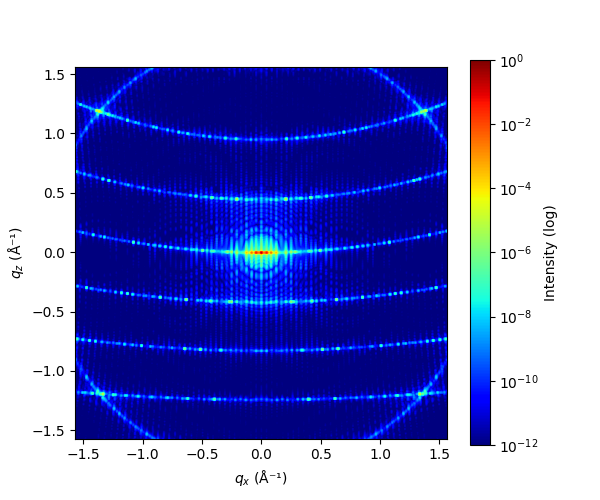

In [31]:
Fq = d.compute_structure_factor(N,Z)
d.plot_intensity(Fq,vmin=-12)


In [32]:
Fq_map = Fq.reshape([npix,npix])


## III. Compute Intensity

$$ I(q) = <P(q)>_{r,L,y,z} * S(q)$$

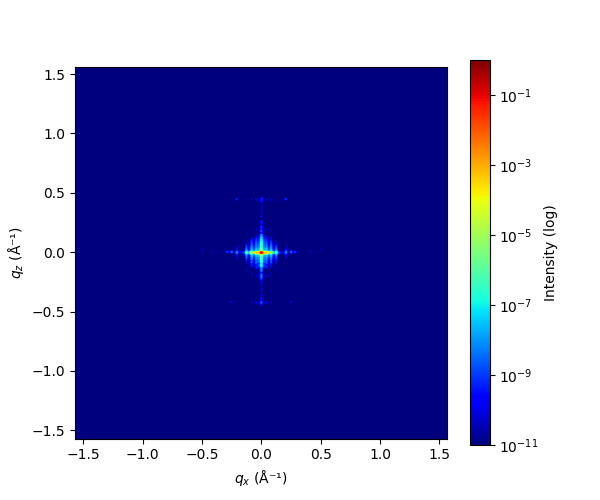

In [34]:
I = Pq_mean_uniaxial*Fq_map
d.plot_intensity(I,vmin=-11)

In [37]:
file='CoNRs_I_polydisp_uniaxial_honeycomb.npz'
save_intensity_npz(file,I,d.Qx,d.Qz)

Saved intensity map to 'CoNRs_I_polydisp_uniaxial_honeycomb.npz'


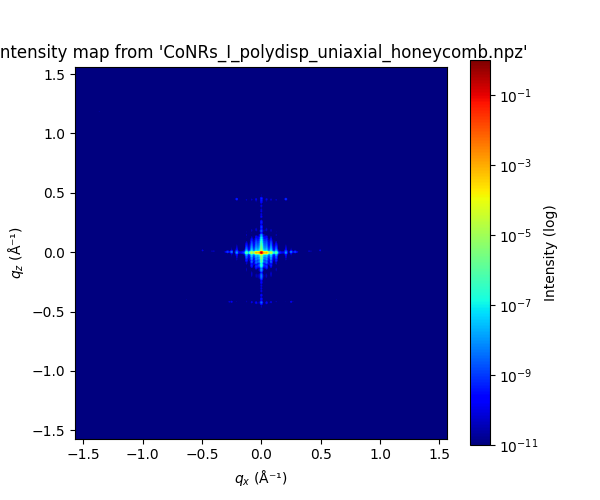

In [39]:
file='CoNRs_I_polydisp_uniaxial_honeycomb.npz'
plot_from_npz(file,vmin=-11)